In [1]:
# %%
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from src.collision_operator_1D import CollisionOperator1D
from model.deeponet import *

# %%
n_q = 100
Q = CollisionOperator1D(integrator_order=n_q)
omega = Q.get_quad_pts()
w_q = Q.get_quad_weights()

# %%
gparams = {
    "name": "3_8_3_8_wo_bias",
    "seed": 0,
    "use_squeue": False,
    "dimension": 1,
    "data_file": "legendre",
    "integration_order": 100,
    "model": "deeponet",
    "branch_hidden": [100, 8, 8, 8],
    "trunk_hidden": [1, 8, 8, 8],
    "act": "tanh",
    "d_out": 1,
    "use_bias": "no",
    "use_gram": False,
    "batch_size": 0,
    "epochs": 100000,
    "lr": 0.001,
    "lambda": 0.0,
}
names = [
    "wo_bias",
    "w_bias",
    "soft_lamb01",
    "hard_gram",
    "hard_special",
]
list_filename = [
    "1D/entropy/3_64_3_64_wo_bias",
    "1D/entropy/3_64_3_64_w_bias",
    "1D/entropy/3_64_3_64_soft_lamb01",
    "1D/entropy/3_64_3_64_hard_gram",
    "1D/entropy/3_64_3_64_hard_special",
]

integration_order = gparams["integration_order"]
if gparams["dimension"] == 1:
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1, 1).cpu()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cpu()
    size_domain = 2

train_data = np.load("data/1D/entropy_train_data.npz")
test_data = np.load("data/1D/entropy_test_data.npz")
tf = train_data["data_f"]
tq = train_data["data_Q"]

# %%
models = []
n_basiss = []
for idx_model, model in enumerate(list_filename):
    args = torch.load(
        "results/" + list_filename[idx_model] + "/args.bin",
        map_location=torch.device("cpu"),
    )
    gparams = args.__dict__
    branch_hidden = gparams["branch_hidden"]
    trunk_hidden = gparams["trunk_hidden"]
    act = gparams["act"]
    output_d_out = gparams["d_out"]
    if gparams["use_bias"] == "no":
        use_bias = False
    else:
        use_bias = gparams["use_bias"]
    if gparams["use_bias"] == "no" and gparams["use_gram"] == False:
        n_basis = trunk_hidden[-1]
    else:
        n_basis = trunk_hidden[-1] + 1
    use_gram = gparams["use_gram"]
    ## We want a cpu model
    if gparams["model"] == "deeponet":
        DeepONet = deeponet(
            branch_hidden,
            trunk_hidden,
            act,
            output_d_out,
            use_bias,
            use_gram,
            quad_w,
            size_domain,
        ).cpu()
        save_model = torch.load(
            "results/" + model + "/final.bin", map_location=torch.device("cpu")
        )
        DeepONet.load_state_dict(save_model["state_dict"])
    models.append(DeepONet)
    n_basiss.append(n_basis)


# %%
def boltz_dom(t, f, Q):
    return Q.evaluate_Q(f) / 4 / np.pi


def boltz_nn(t, f, model):
    mass = w_q @ f
    if mass == 0:
        collision = np.zeros(f.shape)
    else:
        f_normalized = f / mass * 3.5449
        _f = torch.FloatTensor(f_normalized.reshape(1, 1, -1))
        collision = model(_f, grid).squeeze().detach().numpy() * mass / 3.5449

    return collision



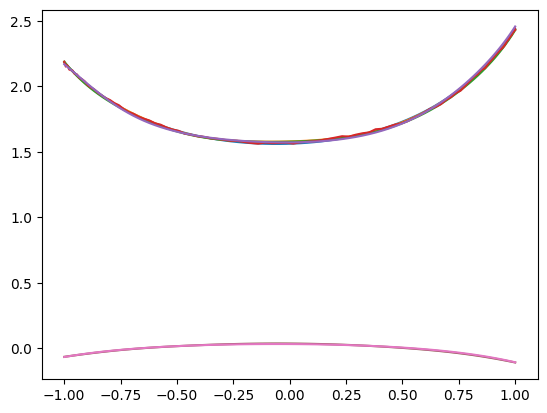

In [2]:

# %%
# f0 = np.random.rand(n_q)
f0 = tf[0, :]
# f0 = np.zeros(n_q)
# for i in range(n_q):
#    f0[i] = np.sin(i * 2.0 * np.pi / (n_q - 1)) + 1

# %% solution trajectory
tspan = [0, 5]
sole = solve_ivp(boltz_dom, tspan, f0, args=(Q,), method="RK45", max_step=0.1)
soln0 = solve_ivp(boltz_nn, tspan, f0, args=(models[0],), method="RK45", max_step=0.1)
soln1 = solve_ivp(boltz_nn, tspan, f0, args=(models[1],), method="RK45", max_step=0.1)
soln2 = solve_ivp(boltz_nn, tspan, f0, args=(models[2],), method="RK45", max_step=0.1)

# %%
soln3 = solve_ivp(boltz_nn, tspan, f0, args=(models[3],), method="RK45", max_step=0.1)
soln4 = solve_ivp(boltz_nn, tspan, f0, args=(models[4],), method="RK45", max_step=0.1)





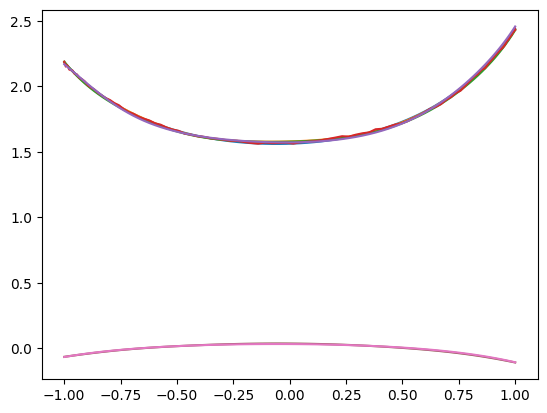

In [5]:
# %%
idx = 50
plt.plot(omega, sole.y[:, idx])
plt.plot(omega, soln0.y[:, idx])
plt.plot(omega, soln1.y[:, idx])
plt.plot(omega, soln3.y[:, idx])  # ! oscillation here
plt.plot(omega, soln4.y[:, idx])

# %%
# collision integral
c = boltz_nn(1.0, sole.y[:, idx], models[1])
c1 = boltz_dom(1.0, sole.y[:, idx], Q)
plt.plot(omega, c)
plt.plot(omega, c1)



In [6]:
# %%
mass = np.zeros((sole.t.shape[0], 6))
for i in range(sole.t.shape[0]):
    mass[i, 0] = w_q @ sole.y[:, 0]
    mass[i, 1] = w_q @ soln0.y[:, i]
    mass[i, 2] = w_q @ soln1.y[:, i]
    mass[i, 3] = w_q @ soln2.y[:, i]
    mass[i, 4] = w_q @ soln3.y[:, i]
    mass[i, 5] = w_q @ soln4.y[:, i]

In [7]:
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

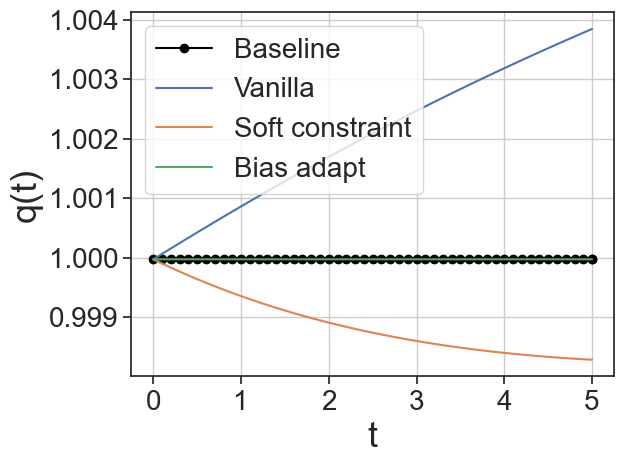

In [26]:
# %%
fig, ax = plt.subplots()
plt.plot(sole.t, mass[:, 0]/3.5450, label="Baseline", marker ='o',color='black')
#plt.plot(sole.t, mass[:, 1]/3.5450, label="wo_bias")
plt.plot(sole.t, mass[:, 3]/3.5450, label="Vanilla")
plt.plot(sole.t, mass[:, 2]/3.5450, label="Soft constraint")
#plt.plot(sole.t, mass[:, 4], label="gram")
plt.plot(sole.t, mass[:, 5]/3.5450, label="Bias adapt")
ax.legend(fontsize=20)
plt.grid(True)
plt.xlabel('t',fontsize=26)
plt.ylabel('q(t)',fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig("mass_evolution.pdf")

# %%
